In [1]:
import time
import numpy as np
from constants import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from build_model import model_tools

X = np.load('Norm_MinMax_%d_X.npy' % window_size)
y = np.load('Norm_MinMax_%d_y.npy' % window_size)

labels = np.unique(y)

le = LabelEncoder()
le.fit(y)
le_y = np.array(le.transform(y))
le_y = le_y.reshape((-1, 1))

ohe = OneHotEncoder()
ohe.fit(le_y)

y = ohe.transform(le_y).toarray()

In [2]:
model = model_tools(X, y, test_size=0.4, model_name='lstm_keras')

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 2,146
Trainable params: 2,146
Non-trainable params: 0
_________________________________________________________________


===================] - 1s 6ms/step - loss: 0.6738 - accuracy: 0.5912 - auc: 0.6172 - val_loss: 0.6228 - val_accuracy: 0.6542 - val_auc: 0.7849 - lr: 0.0010
Epoch 6/100
159/159 [==============================] - 1s 7ms/step - loss: 0.5988 - accuracy: 0.6855 - auc: 0.7536 - val_loss: 0.4759 - val_accuracy: 0.8692 - val_auc: 0.9186 - lr: 0.0010
Epoch 7/100
159/159 [==============================] - 1s 6ms/step - loss: 0.6187 - accuracy: 0.7107 - auc: 0.7354 - val_loss: 0.7160 - val_accuracy: 0.4860 - val_auc: 0.7144 - lr: 0.0010
Epoch 8/100
159/159 [==============================] - 1s 6ms/step - loss: 0.6876 - accuracy: 0.4969 - auc: 0.5376 - val_loss: 0.6645 - val_accuracy: 0.8879 - val_auc: 0.9596 - lr: 0.0010
Epoch 9/100
154/159 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6494 - auc: 0.6538
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
159/159 [==============================] - 1s 6ms/step - loss: 0.6738 - accuracy: 0.6478 

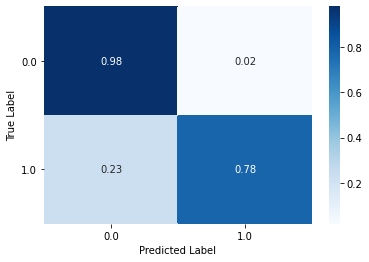

In [3]:
if not os.path.isdir(result_dir):  # For training
    os.mkdir(result_dir)
model.fit_and_save_model(es=False, mc=False, rlr=True, log=True)

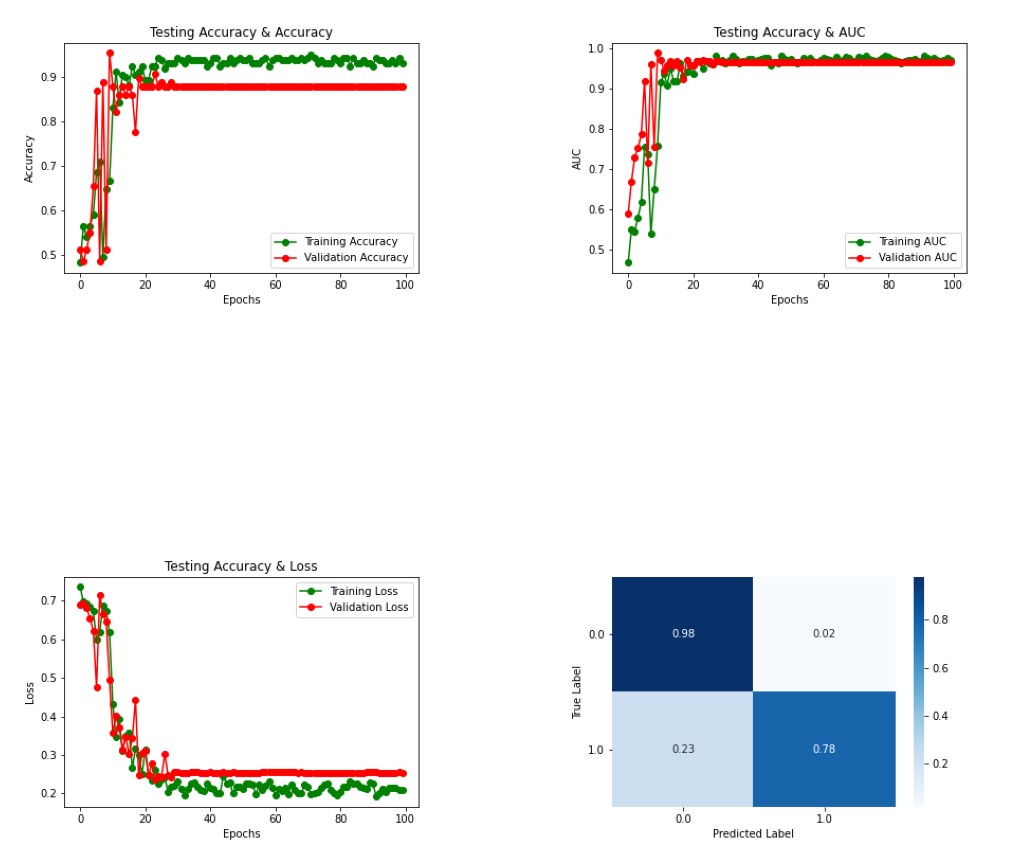

In [4]:
model.plt_fig()